<a href="https://colab.research.google.com/github/atif4/Q2/blob/gh-pages/flower_images_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2
import shutil
import random as rn
from tqdm import tqdm

In [3]:
import os
import zipfile

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

In [6]:
!kaggle datasets download -d alxmamaev/flowers-recognition

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
Zip_ref = zipfile.ZipFile("/content/flowers-recognition.zip")
Zip_ref.extractall("/tmp")
Zip_ref.close()

In [8]:
data_dir = '/tmp/flowers'

In [9]:
print(os.listdir("/tmp/flowers"))
     

['tulip', 'dandelion', 'daisy', 'rose', 'sunflower']


In [10]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width),
                                                             batch_size=batch_size)
#seed once gerenate the random number it save for forever

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [14]:
class_names_va = val_ds.class_names
print(class_names_va)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


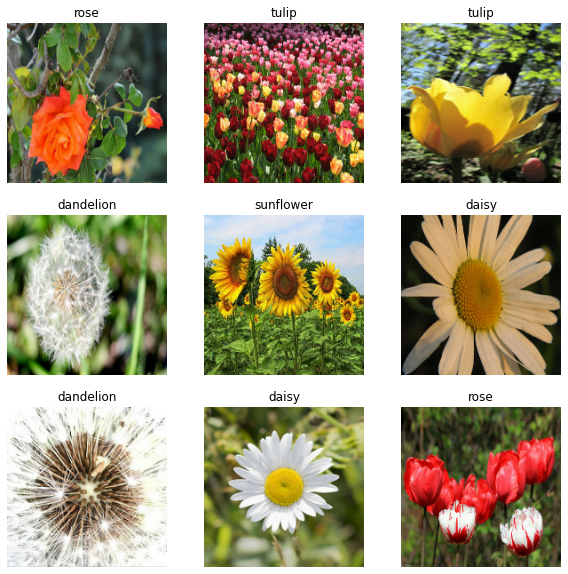

In [15]:
# Here are the first 9 images from the training dataset.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
# 32 are tensors , 180 is width, 180 is hight, 3 are chanel 
"""The image_batch is a tensor of the shape (32, 180, 180, 3).
This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.call .
numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray."""

(32, 180, 180, 3)
(32,)


'The image_batch is a tensor of the shape (32, 180, 180, 3).\nThis is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).\nThe label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.call .\nnumpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.'

In [ ]:
"""Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking.
These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. 
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the data performance guide."""

"Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking.\nThese are two important methods you should use when loading data.\n\nDataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. \nThis will ensure the dataset does not become a bottleneck while training your model. \nIf your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.\n\nDataset.prefetch() overlaps data preprocessing and model execution while training.\n\nInterested readers can learn more about both methods, as well as how to cache data to disk in the data performance guide."

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
AUTOTUNE

-1

In [ ]:
#Standardize the data:

"""The RGB channel values are in the [0, 255] range. 
This is not ideal for a neural network; in general you should seek to make your input values small. 
Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer."""

'The RGB channel values are in the [0, 255] range. \nThis is not ideal for a neural network; in general you should seek to make your input values small. \nHere, you will standardize values to be in the [0, 1] range by using a Rescaling layer.'

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
#There are two ways to use this layer. You can apply it to the dataset by calling map::

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [21]:
"""Create the model::

The model consists of three convolution blocks with a max pool layer in each of them.
There's a fully connected layer with 128 units on top of it that is activated by a relu activation function.
This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach."""
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
#compile the model::
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [23]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
108/108 [==============================] - 142s 1s/step - loss: 1.2354 - accuracy: 0.4719 - val_loss: 1.0925 - val_accuracy: 0.5794
Epoch 2/10
108/108 [==============================] - 133s 1s/step - loss: 0.9877 - accuracy: 0.6031 - val_loss: 0.9971 - val_accuracy: 0.5910
Epoch 3/10
108/108 [==============================] - 127s 1s/step - loss: 0.8614 - accuracy: 0.6671 - val_loss: 0.9942 - val_accuracy: 0.6315
Epoch 4/10
108/108 [==============================] - 132s 1s/step - loss: 0.7521 - accuracy: 0.7044 - val_loss: 0.8469 - val_accuracy: 0.6732
Epoch 5/10
108/108 [==============================] - 129s 1s/step - loss: 0.6332 - accuracy: 0.7554 - val_loss: 0.8928 - val_accuracy: 0.6813
Epoch 6/10
108/108 [==============================] - 132s 1s/step - loss: 0.4892 - accuracy: 0.8185 - val_loss: 0.9651 - val_accuracy: 0.6952
Epoch 7/10
108/108 [==============================] - 132s 1s/step - loss: 0.3833 - accuracy: 0.8625 - val_loss: 1.1140 - val_accuracy: 0.6813

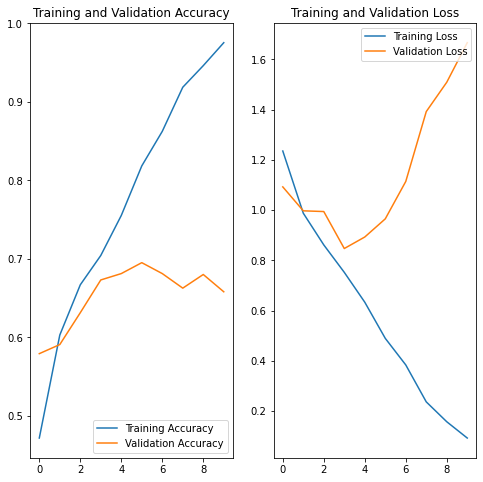

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Overfitting::
"""
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around
60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a
sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from 
training examples—to an extent that it negatively impacts the performance of the model on new examples.
This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a 
new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation 
and add Dropout to your model. Data augmentation::"""

"""Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach
of generating additional training data from your existing examples by augmenting them using random transformations
that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing.
These can be included inside your model like other layers, and run on the GPU."""

'Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach\nof generating additional training data from your existing examples by augmenting them using random transformations\nthat yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.\n\nYou will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing.\nThese can be included inside your model like other layers, and run on the GPU.'

In [25]:
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip
                                      ("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),])

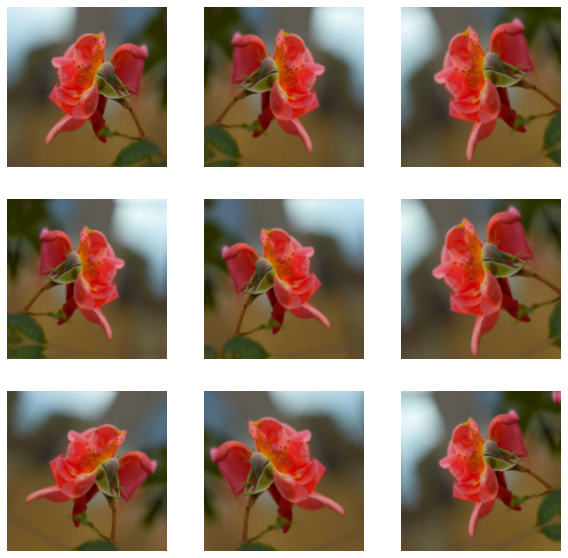

In [26]:
# Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Dropout::
"""Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.
When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units
from the layer during the training process. Dropout takes a fractional number as its input value, in the form
such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images."""

"Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.\nWhen you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units\nfrom the layer during the training process. Dropout takes a fractional number as its input value, in the form\nsuch as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.\n\nLet's create a new neural network using layers.Dropout, then train it using augmented images."

In [27]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [29]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [30]:
epochs=20
history = model.fit(train_ds,  validation_data=val_ds,  epochs=epochs)

Epoch 1/20
108/108 [==============================] - 129s 1s/step - loss: 1.3184 - accuracy: 0.4349 - val_loss: 1.0728 - val_accuracy: 0.5597
Epoch 2/20
108/108 [==============================] - 131s 1s/step - loss: 1.0317 - accuracy: 0.5955 - val_loss: 0.9791 - val_accuracy: 0.6130
Epoch 3/20
108/108 [==============================] - 128s 1s/step - loss: 0.9461 - accuracy: 0.6294 - val_loss: 0.9498 - val_accuracy: 0.6396
Epoch 4/20
108/108 [==============================] - 127s 1s/step - loss: 0.8926 - accuracy: 0.6613 - val_loss: 0.8926 - val_accuracy: 0.6396
Epoch 5/20
108/108 [==============================] - 132s 1s/step - loss: 0.8457 - accuracy: 0.6778 - val_loss: 0.8335 - val_accuracy: 0.6674
Epoch 6/20
108/108 [==============================] - 127s 1s/step - loss: 0.8104 - accuracy: 0.6931 - val_loss: 0.7903 - val_accuracy: 0.7010
Epoch 7/20
108/108 [==============================] - 132s 1s/step - loss: 0.7737 - accuracy: 0.6975 - val_loss: 0.8493 - val_accuracy: 0.6802

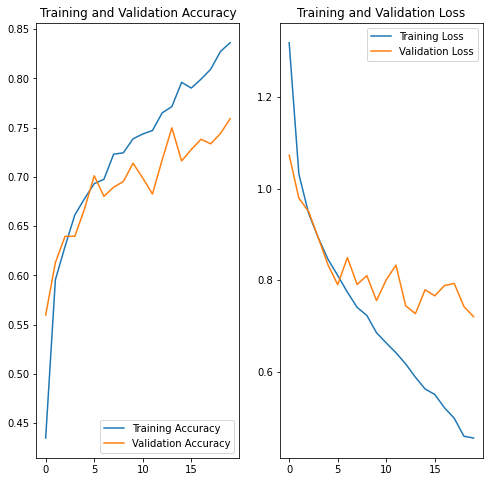

In [31]:
#sualize training results::
#After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
#Deploy model on colab.
#List classes with numbers of classes:
#'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4
import numpy as np
from google.colab import files
from keras.preprocessing import image
uploaded=files.upload()
     

Saving 0010.png to 0010.png


In [33]:
#Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable.
#Saving tulip.jpg to tulip.jpg
import keras.utils as image
for fn in uploaded.keys():
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(180, 180))
  x=image.img_to_array(img)
  test_img=np.expand_dims(x, axis=0)  
  result = model.predict(test_img)
  pred = np.argmax(result) # get the index of max value
  print(pred)

1/1 [==============================] - 0s 218ms/step
2
